In [6]:
from phonecodes import phonecodes
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from torch.nn import Transformer
from torch import Tensor
from sklearn.model_selection import train_test_split
import copy
import tqdm
import librosa
import seaborn as sns
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import textgrid
from scipy.spatial.distance import euclidean
import plotly.graph_objects as go
import pandas as pd
import jiwer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict
from transformers import AutoProcessor, AutoModelForCTC
from phonemizer.backend.espeak.wrapper import EspeakWrapper
import soundfile as sf

_ESPEAK_LIBRARY = r"C:\Program Files\eSpeak NG\libespeak-ng.dll"
EspeakWrapper.set_library(_ESPEAK_LIBRARY)
processor_P = AutoProcessor.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
model_P = AutoModelForCTC.from_pretrained("facebook/wav2vec2-lv-60-espeak-cv-ft")
from transformers import Wav2Vec2ForCTC
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
c:\Users\Alex\anaconda3\envs\BayesPCN\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-lv-60-espeak-cv-ft were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a m

In [32]:
def get_pathset(paths):
    return [os.path.join(dir, each_file) for dir, mid, files in os.walk(paths) for each_file in files if each_file.endswith(".wav")]
def CTC_index(processor,outind):
    meaningful_ids = []
    meaningful_indices = []
    previous_id = -1  
    blank_token_id = processor.tokenizer.pad_token_id  
    for i, token_id in enumerate(outind[0]):  
        if token_id != previous_id and token_id != blank_token_id:
            meaningful_ids.append(token_id.item())  
            meaningful_indices.append(i)  
        previous_id = token_id
    return meaningful_indices

def build_exposure_set(paths, native_dict, set_list, model,processor):
    diphone_dict={}
    uniphone_dict={}

    for each_sentence in paths:
        tg = textgrid.TextGrid.fromFile(each_sentence[:-3]+"TextGrid")
        tg_sentence = [i for i in tg[0] if i.mark!=""]
        tg_sentence = [each for _,each in enumerate(tg_sentence) if _ in set_list]
        
        wave, sr = librosa.load(each_sentence)
        wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
        #wave_res = wave_res[:int(sentence16_end_time*16000)]
        for each_tg in tg_sentence:
            #each_phonemes =[arpabet_to_ipa[i.mark] for i in tg[-1] if each_tg.minTime<=i.minTime and each_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"]
            start=round(each_tg.minTime*16000)
            end=round(each_tg.maxTime*16000)
            input=processor(wave_res[start:end],sampling_rate=16000, return_tensors="pt").input_values
            input=input.to(device)
            model.to(device)
            with torch.no_grad():
                out_encoder1=model(input).logits
            out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().detach().numpy()
            outind=torch.argmax(out_encoder1,dim=-1).cpu().numpy()
            
            indices=[_ for _,i in enumerate(outind[0]) if i>=5 ]
            letter_label=[list(processor.tokenizer.get_vocab().keys())[i] for _,i in enumerate(outind[0]) if i>=5]
            features=out_FE[indices,:]
            #transcription = processor.batch_decode(outind)[0].split(" ")
            #phonemeindex = CTC_index(processor,outind)
            
            
            for i in range(len(letter_label)-1):
                key = (letter_label[i], letter_label[i + 1])
                if key not in diphone_dict:
                    diphone_dict[key] = []

                diphone_dict[key].append(np.vstack((features[i], features[i + 1])))
 
            for i in range(len(letter_label)):
                if letter_label[i] not in uniphone_dict:
                    uniphone_dict[letter_label[i]]=[]
                uniphone_dict[letter_label[i]].append(features[i])

        torch.cuda.empty_cache()
    torch.cuda.empty_cache()
    return diphone_dict,uniphone_dict

In [37]:
def get_test_list(file_path,key_word,sentenceID,model,processor):
    sentenceID=int(sentenceID[-3:])-1
    tg = textgrid.TextGrid.fromFile(file_path[:-3]+"TextGrid")
    tg_sentence = [i for i in tg[0] if i.mark!=""][sentenceID]
    tg_word = [i for i in tg[1] if i.mark!="" and i.mark!="sp"]
    wave, sr = librosa.load(file_path)
    wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)

    for each_word_tg in tg_word:
        if each_word_tg.mark.lower()==key_word:
            if each_word_tg.minTime >= tg_sentence.minTime and each_word_tg.maxTime <= tg_sentence.maxTime:
                start=each_word_tg.minTime
                end=each_word_tg.maxTime
                break
    out_list=[]

    sentence_total_length=tg_sentence.maxTime-tg_sentence.minTime
    word_cut_start=start-tg_sentence.minTime
    word_cut_end=end-tg_sentence.minTime
    
    input=processor(wave_res[int(tg_sentence.minTime*16000):round(tg_sentence.maxTime*16000)], sampling_rate=16000, return_tensors="pt").input_values.to(device)
    with torch.no_grad():
        out_encoder=model(input.to(device)).logits
        out_FE=model.wav2vec2.feature_extractor(input)[0].transpose(1,0).cpu().numpy()
    
    word_start=round(out_encoder.shape[1]*word_cut_start/sentence_total_length)
    word_end=round(out_encoder.shape[1]*word_cut_end/sentence_total_length)
    outind=torch.argmax(out_encoder,dim=-1).cpu().numpy()
    
    indices=[_ for _,i in enumerate(outind[0]) if i>=5 and _>=word_start and _<=word_end]
    letter_label=[list(processor.tokenizer.get_vocab().keys())[i] for _,i in enumerate(outind[0]) if i>=5 and _>=word_start and _<=word_end]
    features=out_FE[indices,:]
    
    if len(indices)<2:
        diphone_key = tuple(letter_label[0])
        out_list.append((diphone_key, features[0]))

    else:
        for i in range(len(letter_label)-1):
            diphone_key = (letter_label[i] , letter_label[i + 1])
        #print(indices)
        out_list.append((diphone_key, np.vstack((features[i], features[i + 1]))))
    torch.cuda.empty_cache()
    return out_list

In [46]:
def get_training_paths(TrainingTalkerID,all_path):
    path_list=[]
    TalkerID=[]
    for each_ID in TrainingTalkerID.split(", "):
        if each_ID[:3]=="CMN":
            TalkerID.append(f"ALL_{each_ID[-3:]}_M_CMN_ENG_HT1")
        else:
            TalkerID.append(f"ALL_{each_ID[-3:]}_M_ENG_ENG_HT1")
    
    for each_path in TalkerID:
        for i in all_path:
            if each_path in i:
                path_list.append(i)
                break
    return path_list

def sim_measure(df, model, processor):
    sim_mean_max_list,sim_mean_std_list,sim_mean_mean_list,isincluded_list,diphone_count =[], [], [], [], []


    train_set_dict={}
    test_word_dict={}
    test_matrix_dict={}
    for each_ in tqdm.tqdm(df.values):
        filename_loc=df.columns.get_loc("Filename")
        keyword_loc=df.columns.get_loc("Keyword")
        training_talker_loc=df.columns.get_loc("TrainingTalkerID")
        
        all_path=get_pathset(r"..\Nov10\speech_files")
        #all_ENG_ENG_pathset=[s.replace("raw_L1", "raw") for s in get_pathset(r"..\data\raw_L1")]
        
        set1_list=[0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]
        set2_list=[17,18,19,20,21,22,24,25,26,27,28,29,30,31,37,40]
        if each_[df.columns.get_loc("TrainingTestSet")] == "set2,set1":
            train_set=set2_list
            test_set=set1_list
        else:
            train_set=set1_list
            test_set=set2_list
        
        #print(each_[filename_loc])
        test_file = [each for each in all_path if os.path.split(each_[filename_loc])[-1][:-5] in each]
        #print(test_file)
        key_word = each_[keyword_loc] #string
        TrainingTalkerID = each_[training_talker_loc] #list of string
        sentenceID = each_[df.columns.get_loc("SentenceID")]
        training_files_path=get_training_paths(TrainingTalkerID,all_path)
        
        if TrainingTalkerID not in train_set_dict:
            train_set_dict[TrainingTalkerID]={}
            
        if each_[df.columns.get_loc("TrainingTestSet")] not in train_set_dict[TrainingTalkerID]:
            training_dict_di, training_dict_uni=build_exposure_set(training_files_path, {}, train_set, model, processor)#copy.deepcopy(all_eng_dict)
            train_set_dict[TrainingTalkerID][each_[df.columns.get_loc("TrainingTestSet")]]=(copy.deepcopy(training_dict_di),copy.deepcopy(training_dict_uni))
        else:
            training_dict_di, training_dict_uni=train_set_dict[TrainingTalkerID][each_[df.columns.get_loc("TrainingTestSet")]]
        
        
        
        if test_file[0] not in test_word_dict:
            test_word_dict[test_file[0]]={}
        if sentenceID not in test_word_dict[test_file[0]]:
            test_word_dict[test_file[0]][sentenceID]={}
        if key_word not in test_word_dict[test_file[0]][sentenceID]:
            test_list = get_test_list(test_file[0], key_word, sentenceID, model, processor)
            test_word_dict[test_file[0]][sentenceID][key_word]=copy.deepcopy(test_list)
        else:
            test_list=test_word_dict[test_file[0]][sentenceID][key_word]

        
        # word level, list
        sim_max=[]
        sim_std=[]
        sim_mean=[]
        isincluded=[]
        #sim_count=[]
        for _, each_diphone in enumerate(test_list):
            sims=[]
            if len(each_diphone[0])==1:
                if each_diphone[0][0] in training_dict_uni.keys():
                    for each_vec in training_dict_uni[each_diphone[0][0]]:
                        current_test_uni=each_diphone[1].ravel()
                        current_test_uni=np.hstack((current_test_uni,current_test_uni))
                        current_e_uni=each_vec.ravel()
                        current_e_uni=np.hstack((current_e_uni,current_e_uni))
                        sim=np.exp(-0.3*euclidean(current_test_uni,current_e_uni))
                        sims.append(sim)
                        isincluded.append(0)
                        
                else:
                    raise IndexError("Uniphone unmatch")
                sim_max.append(np.max(sims))
                sim_std.append(np.std(sims))
                sim_mean.append(np.mean(sims))
            else:
                if each_diphone[0] in training_dict_di.keys():
                    for each_vec in training_dict_di[each_diphone[0]]:
                        sim=np.exp(-0.3*euclidean(each_diphone[1].ravel(),each_vec.ravel()))
                        sims.append(sim)
                        isincluded.append(1)
                        
                else:
                    if each_diphone[0][0] in training_dict_uni.keys() and each_diphone[0][1] in training_dict_uni.keys():
                        for each_vec in training_dict_uni[each_diphone[0][0]]:
                            current_test_uni=each_diphone[1].ravel()[:512]
                            current_test_uni=np.hstack((current_test_uni,current_test_uni))
                            current_e_uni=each_vec.ravel()
                            current_e_uni=np.hstack((current_e_uni,current_e_uni))
                            d=euclidean(current_test_uni,current_e_uni)
                            sims.append(np.exp(-0.3*d))
                        for each_vec in training_dict_uni[each_diphone[0][1]]:
                            current_test_uni=each_diphone[1].ravel()[512:]
                            current_test_uni=np.hstack((current_test_uni,current_test_uni))
                            current_e_uni=each_vec.ravel()
                            current_e_uni=np.hstack((current_e_uni,current_e_uni))
                            sims.append(np.exp(-0.3*euclidean(current_test_uni,current_e_uni)))
                    elif each_diphone[0][0] in training_dict_uni.keys():
                        for each_vec in training_dict_uni[each_diphone[0][0]]:
                            current_test_uni=each_diphone[1].ravel()[:512]
                            current_test_uni=np.hstack((current_test_uni,current_test_uni))
                            current_e_uni=each_vec.ravel()
                            current_e_uni=np.hstack((current_e_uni,current_e_uni))
                            d=euclidean(current_test_uni,current_e_uni)
                            sims.append(np.exp(-0.3*d))
                    elif each_diphone[0][1] in training_dict_uni.keys():
                        for each_vec in training_dict_uni[each_diphone[0][1]]:
                            current_test_uni=each_diphone[1].ravel()[512:]
                            current_test_uni=np.hstack((current_test_uni,current_test_uni))
                            current_e_uni=each_vec.ravel()
                            current_e_uni=np.hstack((current_e_uni,current_e_uni))
                            sims.append(np.exp(-0.3*euclidean(current_test_uni,current_e_uni)))
                    else:
                        sims.append(0)
                    isincluded.append(0)
                sim_max.append(np.max(sims))
                sim_std.append(np.std(sims))
                sim_mean.append(np.mean(sims))
                    
        
        sim_mean_max=np.mean(sim_max)
        sim_mean_std=np.mean(sim_std)
        sim_mean_mean=np.mean(sim_mean)
        
        #X_list.append(X_)
        #Y_list.append(Y_)
        #wav2vec_acc_list.append(np.count_nonzero(phoneme_error)/len(phoneme_error))
        #confusion_matrix_list.append(confusion_matrix)
        sim_mean_max_list.append(sim_mean_max)
        sim_mean_std_list.append(sim_mean_std)
        sim_mean_mean_list.append(sim_mean_mean)
        isincluded_list.append(np.count_nonzero(isincluded)/len(isincluded))
        diphone_count.append(len(isincluded))
        
    return sim_mean_max_list,sim_mean_std_list,sim_mean_mean_list,isincluded_list,diphone_count



In [21]:
human_result_path=r"..\data\test.xlsx"
human_result = pd.read_excel(human_result_path)
human_result_1a=human_result[human_result["Experiment"]=="1a"]

In [5]:
audio_dir =r"..\Nov10\speech_files"
each_sentence=get_pathset(audio_dir)[0]

In [47]:
sim_mean_max_list,sim_mean_std_list,sim_mean_mean_list,isincluded_list,diphone_count=sim_measure(human_result_1a,model, processor)

  0%|          | 0/16477 [00:00<?, ?it/s]

100%|██████████| 16477/16477 [04:40<00:00, 58.67it/s] 


In [48]:
human_result_1a["sim_mean_max"]=sim_mean_max_list
human_result_1a["sim_mean_std"]=sim_mean_std_list
human_result_1a["sim_mean_mean"] = sim_mean_mean_list
human_result_1a["diphone_overlapped_rate"]=isincluded_list
human_result_1a["NumDiphone_word"]=diphone_count
human_result_1a.to_excel('similarities_p_t512.xlsx')


C:\Users\Alex\AppData\Local\Temp\ipykernel_374316\438118633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_result_1a["sim_mean_max"]=sim_mean_max_list
C:\Users\Alex\AppData\Local\Temp\ipykernel_374316\438118633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_result_1a["sim_mean_std"]=sim_mean_std_list
C:\Users\Alex\AppData\Local\Temp\ipykernel_374316\438118633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

<Figure size 1200x800 with 0 Axes>

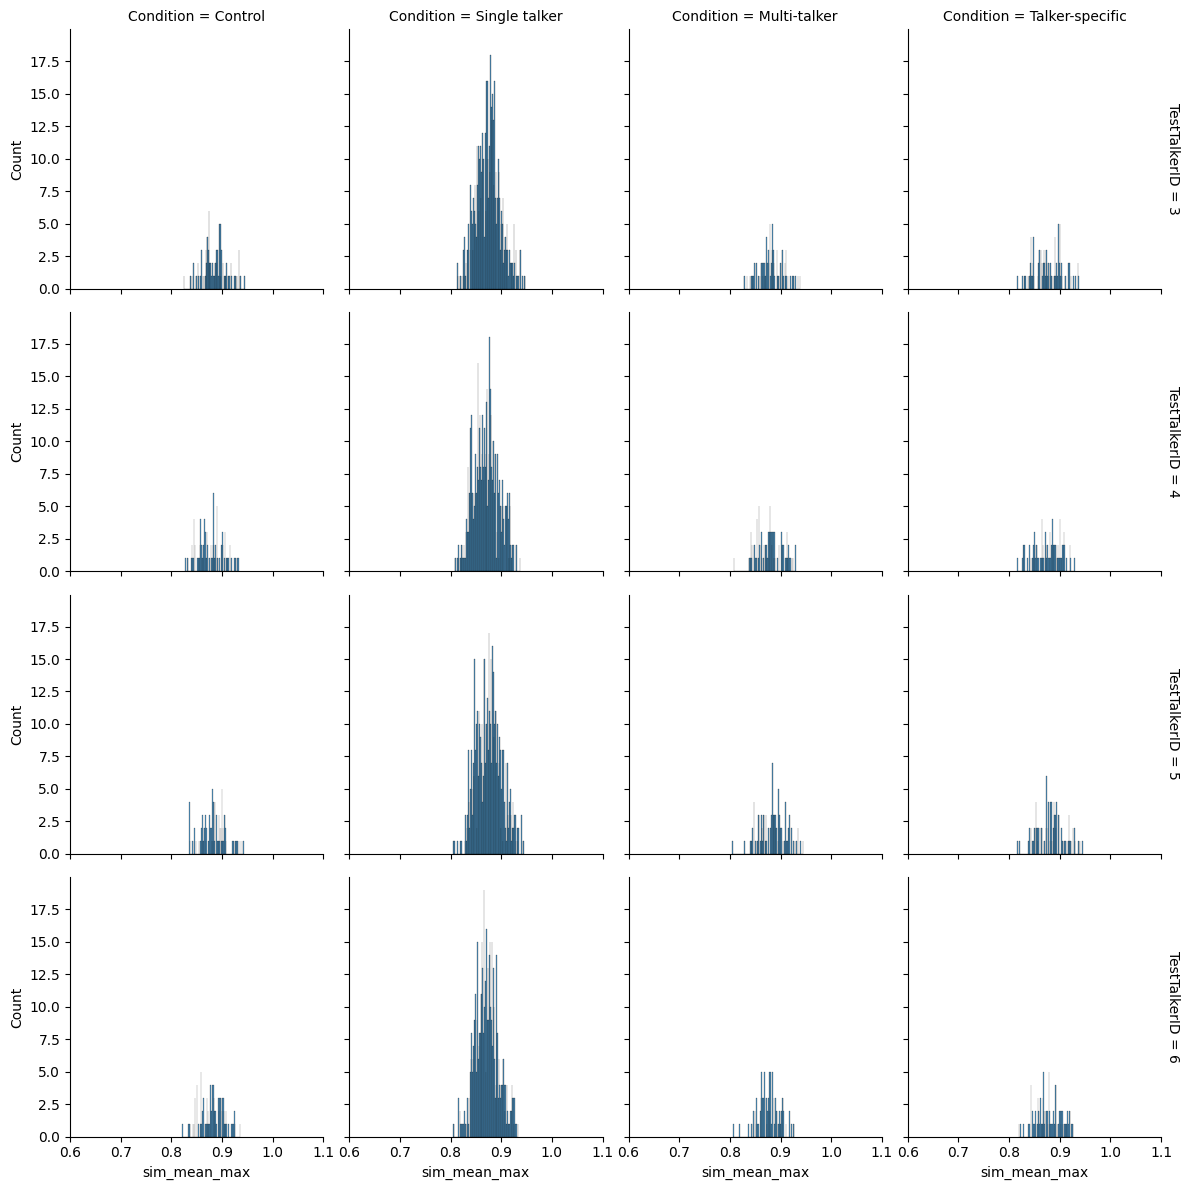

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
d_sim = pd.read_excel("./similarities_p_t512.xlsx")
d_sim = d_sim[(d_sim['Experiment'] == '1a') & (d_sim['PartOfExp'] == 'test')]
d_sim = d_sim.rename(columns={'TrainingTalkerID': 'ExposureTalkerID'})
d_sim['ExposureTalkerID'] = d_sim.apply(
    lambda row: row['ExposureTalkerID'] if row['Condition2'] == 'Single talker' 
    else f"Exposure for {row['Condition2']} - TestTalkerID {row['TestTalkerID']}" if row['Condition2'] in ['Multi-talker', 'Talker-specific'] 
    else f"Exposure for {row['Condition2']}",
    axis=1
)
d_sim['KeywordID'] = pd.factorize(d_sim['Keyword'])[0] + 1
d_sim['ProportionDiphoneOverlap'] = d_sim['diphone_overlapped_rate'] #/ d_sim['NumDiphone_word']
id_columns = ['WorkerID', 'ExposureTalkerID', 'TestTalkerID', 'SentenceID', 'KeywordID']
d_sim[id_columns] = d_sim[id_columns].astype('category')
d_sim['Condition'] = pd.Categorical(d_sim['Condition2'], categories=['Control', 'Single talker', 'Multi-talker', 'Talker-specific'], ordered=True)

grouped_sim = d_sim.groupby(['Condition', 'ExposureTalkerID', 'TestTalkerID', 'SentenceID', 'KeywordID']).agg(
    sim_mean_max=('sim_mean_max', 'mean')
).reset_index()

single_talker_data = grouped_sim[grouped_sim['Condition'] == 'Single talker']
control_data = grouped_sim[grouped_sim['Condition'] == 'Control']
multi_talker_data = grouped_sim[grouped_sim['Condition'] == 'Multi-talker']
talker_specific_data = grouped_sim[grouped_sim['Condition'] == 'Talker-specific']
control_data_expanded = pd.concat([control_data] , ignore_index=True)
multi_talker_data_expanded = pd.concat([multi_talker_data] , ignore_index=True)
talker_specific_data_expanded = pd.concat([talker_specific_data] , ignore_index=True)
balanced_grouped_sim = pd.concat([single_talker_data, control_data_expanded, multi_talker_data_expanded, talker_specific_data_expanded], ignore_index=True)


plt.figure(figsize=(12, 8))
g = sns.FacetGrid(balanced_grouped_sim, row='TestTalkerID', col='Condition', margin_titles=True, sharex=True)
g.map(sns.histplot, 'sim_mean_max', bins=100)
g.set(xlim=(0.6, 1.1))
#g.set(ylim=(-0.1,15))
plt.tight_layout()
plt.show()





In [51]:
d_sim.groupby('Condition').agg(
    {col: 'mean' for col in d_sim.columns if col.startswith('sim')}
).reset_index()


,Condition,sim_mean_max,sim_mean_std,sim_mean_mean
0,Control,0.882709,0.016349,0.848011
1,Single talker,0.873488,0.013053,0.851405
2,Multi-talker,0.880391,0.014140,0.851842
3,Talker-specific,0.878618,0.013627,0.855529


In [7]:
wave, sr = librosa.load(each_sentence)
wave_res = librosa.resample(wave, orig_sr=sr, target_sr=16000)
tg = textgrid.TextGrid.fromFile(each_sentence[:-3]+"TextGrid")
tg_sentence = [i for i in tg[0] if i.mark!=""]
#wave_res = wave_res[:int(sentence16_end_time*16000)]
for each_tg in tg_sentence:
    #each_phonemes =[arpabet_to_ipa[i.mark] for i in tg[-1] if each_tg.minTime<=i.minTime and each_tg.maxTime>=i.maxTime and i.mark!="" and i.mark!="sp" and i.mark!="sil"]
    start=round(each_tg.minTime*16000)
    end=round(each_tg.maxTime*16000)
    input=processor(wave_res[start:end],sampling_rate=16000, return_tensors="pt").input_values
    input=input.to(device)
    model.to(device)
    with torch.no_grad():
        out_encoder1=model(input).logits
    outind=torch.argmax(out_encoder1,dim=-1).cpu().numpy()
    #outind=torch.argmax(out_encoder1,dim=-1).cpu().numpy()
    transcription = processor.batch_decode(outind)[0].split(" ")

In [8]:
transcription

['THE', 'DOG', 'CAME', 'HOME', 'AT', 'LAST']

array([[ 0,  0,  6, 11,  5,  0,  4,  4,  4,  0, 14,  0,  0,  8,  0,  0,
         0,  0,  0,  0, 21,  0,  4,  4,  0,  0,  0,  0,  0, 19,  7,  0,
         0, 17,  0,  5,  0,  4,  4,  4,  0, 11,  0,  0,  8,  0, 17, 17,
         5,  0,  4,  4,  4,  4,  0,  0,  0,  0,  7,  0,  6,  0,  4,  4,
         0,  0,  0, 15, 15,  0,  0,  0,  7,  0,  0,  0,  0,  0, 12,  0,
         0,  6,  0,  0,  4,  4,  4,  4,  0]], dtype=int64)

In [17]:
np.array(list(processor.tokenizer.get_vocab().keys()))[np.array(outind)]

array([['<pad>', '<pad>', 'T', 'H', 'E', '<pad>', '|', '|', '|', '<pad>',
        'D', '<pad>', '<pad>', 'O', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', 'G', '<pad>', '|', '|', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', 'C', 'A', '<pad>', '<pad>', 'M',
        '<pad>', 'E', '<pad>', '|', '|', '|', '<pad>', 'H', '<pad>',
        '<pad>', 'O', '<pad>', 'M', 'M', 'E', '<pad>', '|', '|', '|',
        '|', '<pad>', '<pad>', '<pad>', '<pad>', 'A', '<pad>', 'T',
        '<pad>', '|', '|', '<pad>', '<pad>', '<pad>', 'L', 'L', '<pad>',
        '<pad>', '<pad>', 'A', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', 'S', '<pad>', '<pad>', 'T', '<pad>', '<pad>', '|', '|',
        '|', '|', '<pad>']], dtype='<U5')

In [19]:
letter_label=[list(processor.tokenizer.get_vocab().keys())[i] for _,i in enumerate(outind[0]) if i>=5]
letter_label

['T',
 'H',
 'E',
 'D',
 'O',
 'G',
 'C',
 'A',
 'M',
 'E',
 'H',
 'O',
 'M',
 'M',
 'E',
 'A',
 'T',
 'L',
 'L',
 'A',
 'S',
 'T']

In [20]:
indices=[_ for _,i in enumerate(outind[0]) if i>=5]
indices

[2,
 3,
 4,
 10,
 13,
 20,
 29,
 30,
 33,
 35,
 41,
 44,
 46,
 47,
 48,
 58,
 60,
 67,
 68,
 72,
 78,
 81]